In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras as kr

In [44]:
img_height = 224
img_width = 224
batch_size = 32

train_ds = kr.utils.image_dataset_from_directory(
    "Covid19-dataset/train",
    seed = 42,
    image_size = (img_height,img_width),
    label_mode = 'int',
    class_names={'Covid':0,'Normal': 1, 'Viral Pneumonia': 2},
    shuffle = True,
    batch_size = 64
)
test_ds = kr.utils.image_dataset_from_directory(
    "Covid19-dataset/test",
    seed = 123,
    image_size = (img_height,img_width),
    class_names={'Covid' : 0,'Normal': 1, 'Viral Pneumonia': 2}
)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [64]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  class_2 = labels == 2
  class_2 = tf.cast(class_2, tf.int32)
  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)
  counts['class_2'] += tf.reduce_sum(class_2)

  return counts

counts = train_ds.unbatch().reduce(
    initial_state={'class_0': 0, 'class_1': 0, 'class_2' : 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy(),
                   counts['class_2'].numpy()]).astype(np.float32)
print(counts)
fractions = counts/counts.sum()
print(fractions)


[111.  70.  70.]
[0.4422311  0.27888447 0.27888447]


In [66]:
def class_func(features, label):
  return label

In [67]:
resample_ds = (
    train_ds
    .unbatch()
    .rejection_resample(class_func, target_dist=[0.33,0.33,0.33],
                        initial_dist=fractions)
    .batch(32))

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [68]:
balanced_train_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [69]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = balanced_train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [86]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width,img_height,3),

)



In [87]:
base_model.trainable = False

In [94]:
inputs = kr.Input(shape=(img_width,img_height,3))
mean = np.array([127.5]*3)
var = mean ** 2

norm_layer = kr.layers.experimental.preprocessing.Normalization(mean=mean,variance=var)
x = norm_layer(inputs)

x = base_model(x)
x = kr.layers.GlobalAveragePooling2D()(x)
x = kr.layers.Flatten()(x)
x = kr.layers.Dense(256,activation='relu')(x)
x = kr.layers.Dropout(0.5)(x)
x = kr.layers.Dense(256,activation='relu')(x)
x = kr.layers.Dropout(0.5)(x)
output = kr.layers.Dense(3, activation="softmax")(x)
model_fin = kr.Model(inputs,output)

In [95]:
model_fin.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 normalization_2 (Normalizat  (None, 224, 224, 3)      0         
 ion)                                                            
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               5245

In [96]:
optimzer = kr.optimizers.Adam(learning_rate=0.001)
model_fin.compile(
    optimizer="Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [90]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)


In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(
        zoom_range=0.1,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True
    )
    generator = datagen.flow_from_directory(
        "Covid19-dataset/train",
        batch_size=batch_size,
        seed=42,
        class_mode='binary',
        target_size=(img_height, img_width),
        classes={'Covid':1,'Normal': 0, 'Viral Pneumonia': 1}
    )
    return generator

train_generator = generate_data_augmented(1)

Found 251 images belonging to 3 classes.


In [113]:
train_generator.classes

251

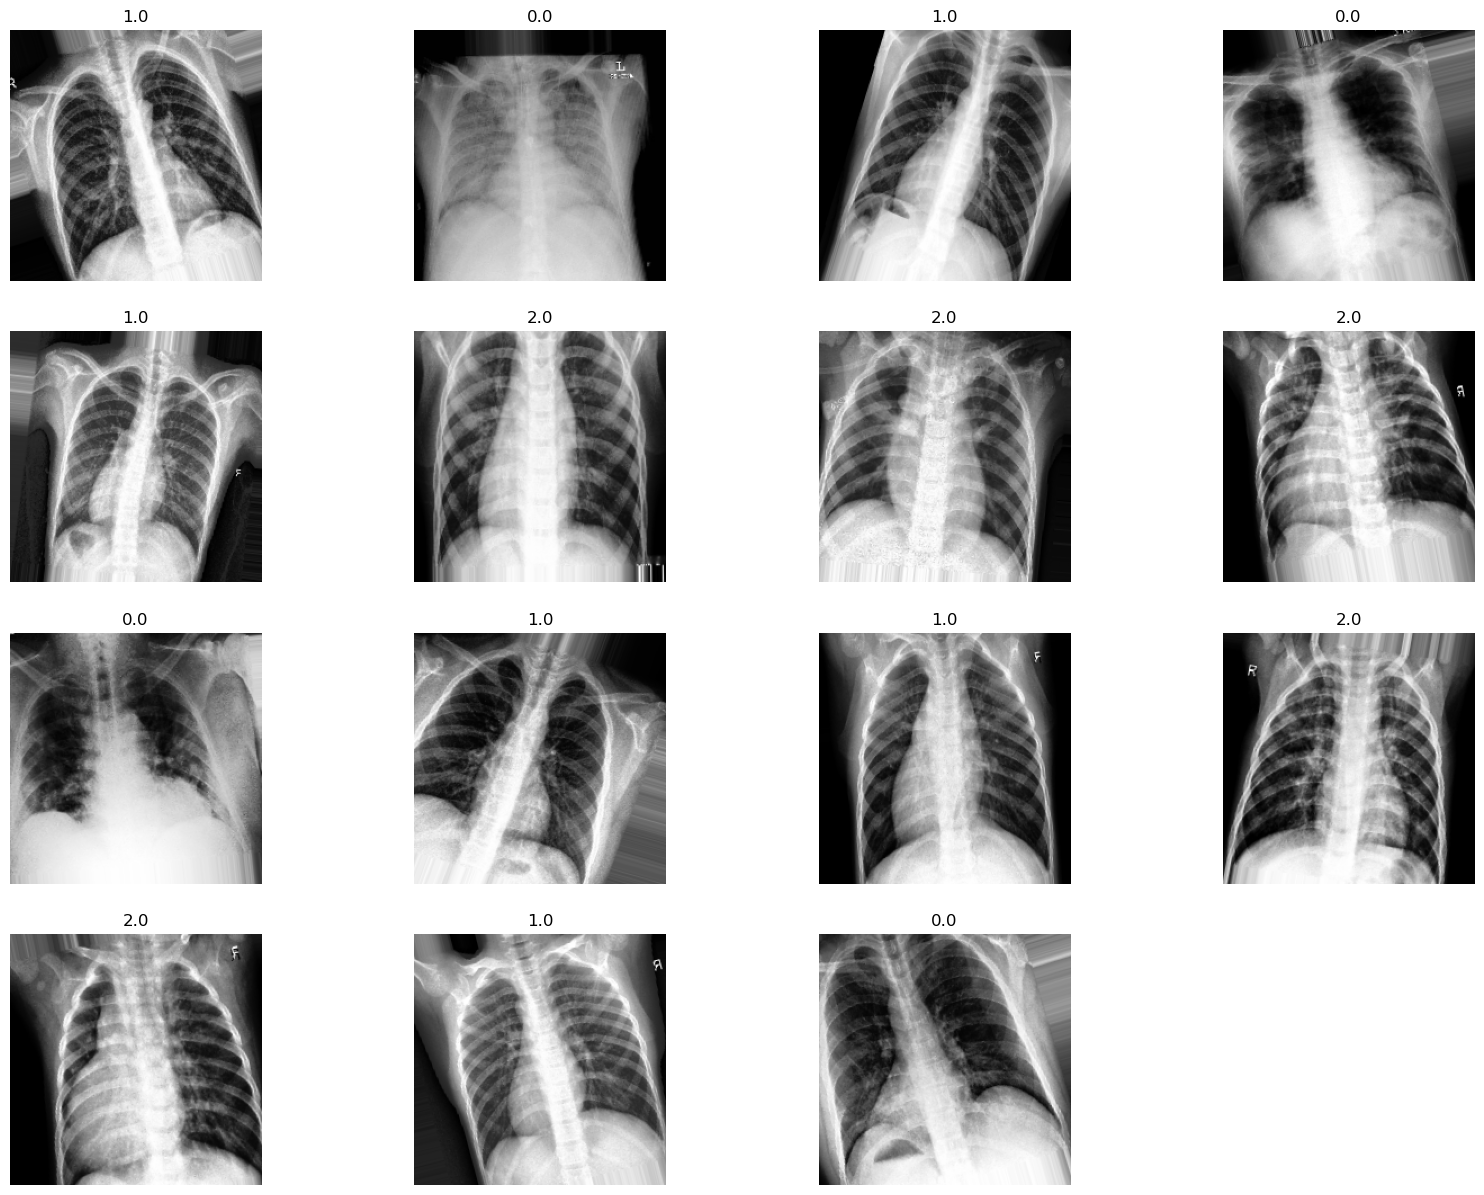

In [76]:
import matplotlib.pyplot as plt
import math
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title(img_label[i])
        plt.axis("off")

image_plot(train_generator,15)

In [97]:
history = model_fin.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks = [early_stop],
    shuffle = False,
)

Epoch 1/50


12/12 [==============================] - 2s 90ms/step - loss: 0.8367 - accuracy: 0.6169 - val_loss: 0.7514 - val_accuracy: 0.6364
Epoch 2/50
12/12 [==============================] - 1s 52ms/step - loss: 0.4583 - accuracy: 0.8197 - val_loss: 0.5898 - val_accuracy: 0.6667
Epoch 3/50
12/12 [==============================] - 1s 52ms/step - loss: 0.3878 - accuracy: 0.8563 - val_loss: 0.2901 - val_accuracy: 0.8939
Epoch 4/50
12/12 [==============================] - 1s 44ms/step - loss: 0.3262 - accuracy: 0.8930 - val_loss: 0.3953 - val_accuracy: 0.8788
Epoch 5/50
12/12 [==============================] - 1s 44ms/step - loss: 0.2523 - accuracy: 0.9099 - val_loss: 0.2904 - val_accuracy: 0.9091
Epoch 6/50
12/12 [==============================] - 1s 44ms/step - loss: 0.2572 - accuracy: 0.9014 - val_loss: 0.2969 - val_accuracy: 0.9091
Epoch 7/50
12/12 [==============================] - 1s 44ms/step - loss: 0.1991 - accuracy: 0.9183 - val_loss: 0.3777 - val_accuracy: 0.8182
Epoch 8/50
12/12 [======

In [98]:
history = model_fin.fit(
    train_generator,
    validation_data=test_ds,
    epochs=50,
    callbacks = [early_stop],
    shuffle = False,
)

Epoch 1/50
8/8 [==============================] - 7s 694ms/step - loss: 0.4530 - accuracy: 0.8486 - val_loss: 0.7073 - val_accuracy: 0.6818
Epoch 2/50
8/8 [==============================] - 6s 725ms/step - loss: 0.3454 - accuracy: 0.8685 - val_loss: 0.2490 - val_accuracy: 0.8788
Epoch 3/50
8/8 [==============================] - 6s 741ms/step - loss: 0.4032 - accuracy: 0.8367 - val_loss: 0.6585 - val_accuracy: 0.6970
Epoch 4/50
8/8 [==============================] - 6s 725ms/step - loss: 0.3017 - accuracy: 0.9044 - val_loss: 0.2242 - val_accuracy: 0.9242
Epoch 5/50
8/8 [==============================] - 6s 724ms/step - loss: 0.3170 - accuracy: 0.8685 - val_loss: 0.3631 - val_accuracy: 0.8788
Epoch 6/50
8/8 [==============================] - 6s 722ms/step - loss: 0.2739 - accuracy: 0.8884 - val_loss: 0.3326 - val_accuracy: 0.8636
Epoch 7/50
8/8 [==============================] - 6s 722ms/step - loss: 0.3185 - accuracy: 0.8924 - val_loss: 0.3498 - val_accuracy: 0.8636
Epoch 8/50
8/8 [====

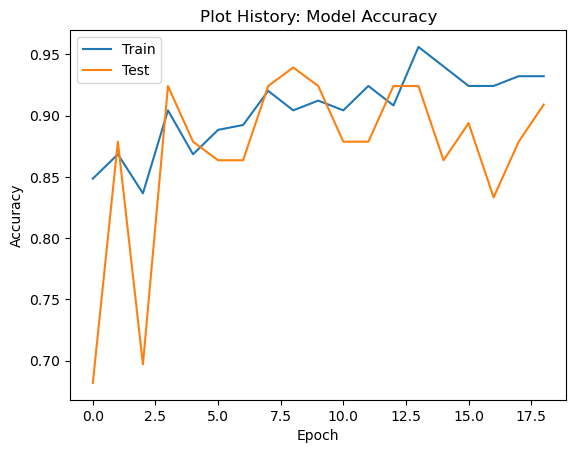

In [99]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Plot History: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [100]:
y_pred = np.argmax(model_fin.predict(val_ds),axis=1)

train_label = np.concatenate([y for x, y in val_ds], axis=0)
test_label = np.concatenate([y for x, y in val_ds], axis=0) 
CM = tf.math.confusion_matrix(labels=test_label,predictions=y_pred).numpy()

3/3 [==============================] - 0s 61ms/step


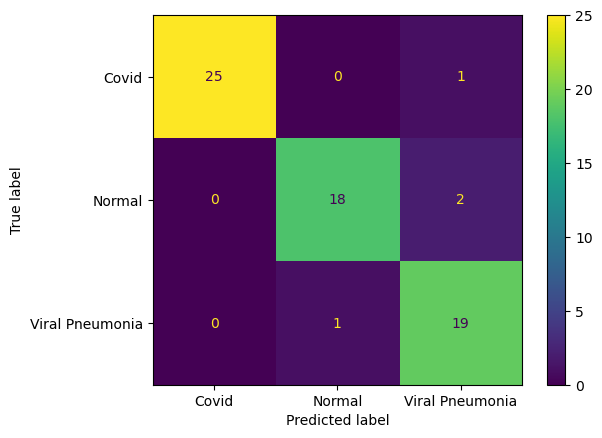

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cd = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = class_names)
cd.plot()
plt.show()

In [51]:
CM

array([[25,  0,  1],
       [ 0, 18,  2],
       [ 0,  2, 18]])

In [52]:
print(f"Precision {class_names[0]} : {CM[0,0]/CM[0].sum()}")
print(f"Precision {class_names[1]} : {CM[1,1]/CM[1].sum()}")
print(f"Precision {class_names[2]} : {CM[2,2]/CM[2].sum()}")

print(f"Recall {class_names[0]} : {CM[0,0]/CM[:,0].sum()}")
print(f"Recall {class_names[1]} : {CM[1,1]/CM[:,1].sum()}")
print(f"Recall {class_names[2]} : {CM[2,2]/CM[:,2].sum()}")


Precision Covid : 0.9615384615384616
Precision Normal : 0.9
Precision Viral Pneumonia : 0.9
Recall Covid : 1.0
Recall Normal : 0.9
Recall Viral Pneumonia : 0.8571428571428571
